In [1]:
%load_ext tensorboard

In [2]:
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, MaxPooling2D, Dropout
from keras.layers import BatchNormalization

In [5]:
import tensorflow as tf
import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

#데이터셋 설정
train_datagen = ImageDataGenerator(rescale=1./255,width_shift_range=0.2,height_shift_range =0.2,
    zoom_range=0.2, horizontal_flip =True, vertical_flip = True)

train_generator = train_datagen.flow_from_directory(
    './mask/train/',
    target_size=(227, 227),
    batch_size=8,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255,width_shift_range=0.2,height_shift_range =0.2,
zoom_range=0.2, horizontal_flip =True, vertical_flip = True)

test_generator = train_datagen.flow_from_directory(
    './mask/val/',
    target_size=(227, 227),
    batch_size=8,
    class_mode='categorical')


Found 199 images belonging to 2 classes.
Found 56 images belonging to 2 classes.


In [6]:
num_classes = 2

sgd = SGD(lr=0.01,decay=5e-4, momentum=0.9)

# AlexNet model
class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()
# AlexNet model
class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= input_shape,
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None)) 

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dense(num_classes, activation= 'softmax'))

        self.compile(optimizer= tf.keras.optimizers.Adam(0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])   
        

In [7]:
model = AlexNet((227, 227, 3), num_classes)
model.summary()

Model: "alex_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 384)       1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 256)       884

In [14]:
# some training parameters
EPOCHS = 100
BATCH_SIZE = 8
image_height = 227
image_width = 227
train_dir = "./mask/train/"
valid_dir = "./mask/val/"
model_dir = "my_model0604.h5"

In [15]:
train_datagen = ImageDataGenerator(
                  rescale=1./255,
                  rotation_range=10,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  shear_range=0.1,
                  zoom_range=0.1)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(image_height, image_width),
                                                    color_mode="rgb",
                                                    batch_size=BATCH_SIZE,
                                                    seed=1,
                                                    shuffle=True,
                                                    class_mode="categorical")

valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size=(image_height, image_width),
                                                    color_mode="rgb",
                                                    batch_size=BATCH_SIZE,
                                                    seed=7,
                                                    shuffle=True,
                                                    class_mode="categorical"
                                                    )

Found 199 images belonging to 2 classes.
Found 56 images belonging to 2 classes.


In [16]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callback_list = [tensorboard_callback]


In [ ]:
# start training
model.fit(train_generator,
                    epochs=EPOCHS,
                    steps_per_epoch=BATCH_SIZE,
                    validation_data=valid_generator,
                    validation_steps=BATCH_SIZE,
                    callbacks=callback_list,
                    verbose=0)

# save the whole model
model.save(model_dir)

In [54]:
%tensorboard --logdir logs/fit/

Reusing TensorBoard on port 6006 (pid 849084), started 0:57:12 ago. (Use '!kill 849084' to kill it.)

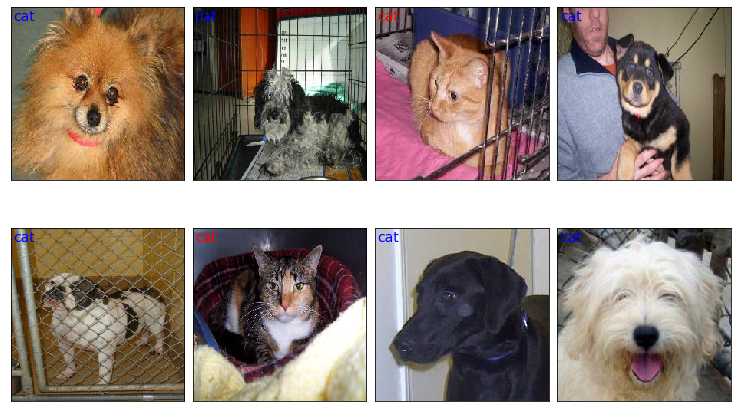

In [38]:
class_names = ['dog', 'cat']

x_valid, label_batch  = next(iter(valid_generator))

prediction_values = model.predict_classes(x_valid)

#prediction_values = np.argmax(model.predict(x_valid), axis=-1)

# set up the figure
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the images: each image is 227x227 pixels
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(x_valid[i,:],cmap=plt.cm.gray_r, interpolation='nearest')
  
    if prediction_values[i] == np.argmax(label_batch[i]):
        # label the image with the blue text
        ax.text(3, 17, class_names[prediction_values[i]], color='blue', fontsize=14)
    else:
        # label the image with the red text
        ax.text(3, 17, class_names[prediction_values[i]], color='red', fontsize=14)

In [36]:
prediction_values[i]

1